In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from quilt.data.ResidentMario import geoplot_data
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd
from shapely.geometry import Point

In [2]:
armed_shootings_by_year = pd.read_csv('raw_data/armed_shootings_clean.csv')

armed_shootings_by_year.head()

,Unnamed: 0,Year,Name
0,0,2000,304
1,1,2001,339
2,2,2002,383
3,3,2003,419
4,4,2004,467


In [3]:
unarmed_shootings_by_year = pd.read_csv('raw_data/unarmed_shootings_clean.csv')

unarmed_shootings_by_year.head()

,Unnamed: 0,Year,Name
0,0,2000,12
1,1,2001,15
2,2,2002,22
3,3,2003,17
4,4,2004,16


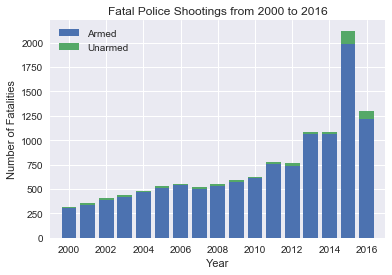

In [8]:
# Use Seaborn stylings
sns.set()

# Plot the number of fatalities by year
p1 = plt.bar(x = armed_shootings_by_year["Year"], height = armed_shootings_by_year["Name"], align = "center")
p2 = plt.bar(x = unarmed_shootings_by_year["Year"], height = unarmed_shootings_by_year["Name"],
       bottom = armed_shootings_by_year["Name"], align = "center")


# Add labels
plt.title("Fatal Police Shootings from 2000 to 2016")
plt.xlabel("Year")
plt.ylabel("Number of Fatalities")
plt.legend((p1[0], p2[0]), ('Armed', 'Unarmed'), loc='best')

# Set x limits
plt.xlim(1999,2017)

plt.show()

In [19]:
continental_usa = gpd.read_file(geoplot_data.contiguous_usa())
continental_usa = continental_usa.set_index("State")

lat_lng_df = pd.read_csv('raw_data/lat_long_states_fatalities.csv')

lat_lng_df.head()

,Unnamed: 0,state name,Fatalities,latitude,longitude
0,0,Alaska,73,64.0685,-52.2782
1,1,Alabama,326,32.7794,-86.8287
2,2,Arkansas,70,34.8938,-92.4426
3,3,Arizona,585,34.2744,-11.6602
4,4,California,2913,37.1841,-19.4696


In [20]:
geometry = [Point(xy) for xy in zip(lat_lng_df.longitude, lat_lng_df.latitude)]
lat_lng_df = lat_lng_df.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(lat_lng_df, crs=crs, geometry=geometry)

gdf.head()

,Unnamed: 0,state name,Fatalities,geometry
0,0,Alaska,73,POINT (-52.2782 64.0685)
1,1,Alabama,326,POINT (-86.8287 32.7794)
2,2,Arkansas,70,POINT (-92.4426 34.8938)
3,3,Arizona,585,POINT (-11.6602 34.2744)
4,4,California,2913,POINT (-19.4696 37.1841)


In [22]:
# Geopandas is limited to continental US, so exclude Alaska and Hawaii
gdf = gdf.loc[(gdf["state name"] != 'Alaska') & (gdf["state name"] != 'Hawaii')]

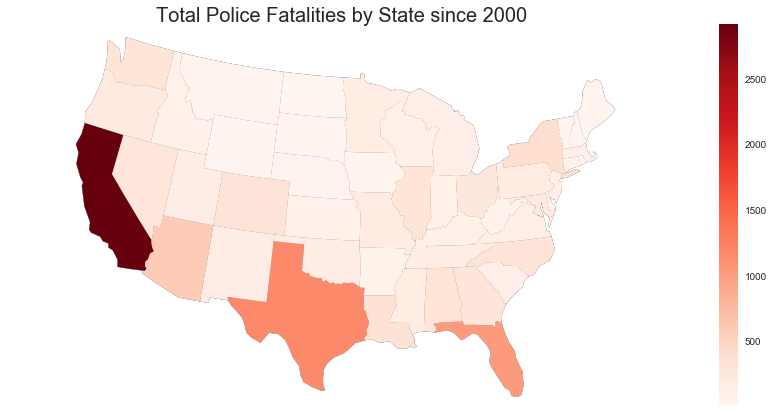

In [23]:
ax = gplt.polyplot(continental_usa, projection=gcrs.AlbersEqualArea(), figsize = (15,7))

gplt.aggplot(gdf, projection=gcrs.AlbersEqualArea(), hue='Fatalities', cmap='Reds',
             by='state name', geometry=continental_usa.geometry, ax=ax,
             linewidth=0)

plt.title("Total Police Fatalities by State since 2000", size = 20)

plt.show()

In [ ]:
# Read in census data
census_df.to_csv("raw_data/mean_populations_by_state.csv")